### Library and Docs

**Installation:**

```
pip install sklearn-genetic-opt[all]
```

**Repo:** [Github](https://github.com/rodrigo-arenas/Sklearn-genetic-opt)

**Documentation:** [sklearn-genetic-opt](https://sklearn-genetic-opt.readthedocs.io/en/stable/index.html)

**PyPI:** [Package](https://pypi.org/project/sklearn-genetic-opt/)

**Related Articles:**
* [Tune Your Scikit-learn Model Using Evolutionary Algorithms](https://towardsdatascience.com/tune-your-scikit-learn-model-using-evolutionary-algorithms-30538248ac16)
* [Evolutionary Feature Selection for Machine Learning](https://towardsdatascience.com/evolutionary-feature-selection-for-machine-learning-7f61af2a8c12)
* [Are You Still Using Grid Search for Hyperparameters Optimization?](https://towardsdatascience.com/hyperparameters-tuning-from-grid-search-to-optimization-a09853e4e9b8)

**Personal Links:**

[LinkedIn](https://co.linkedin.com/in/rodrigo-arenas-gomez)

[Github](https://github.com/rodrigo-arenas)

[Medium](https://rodrigo-arenas.medium.com/)

In [1]:
import warnings
import numpy as np
import optuna

from tensorboard import notebook
from sklearn_genetic import GASearchCV, GAFeatureSelectionCV
from sklearn_genetic import ExponentialAdapter
from sklearn_genetic.space import Continuous, Categorical, Integer
from sklearn_genetic.plots import plot_fitness_evolution, plot_search_space
from sklearn_genetic.callbacks import ThresholdStopping, DeltaThreshold, TensorBoard, TimerStopping
from sklearn_genetic.mlflow_log import MLflowConfig

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from skopt import BayesSearchCV
from skopt.space import Real, Categorical as SkoptCategorical, Integer as SkoptInteger

from tpot import TPOTClassifier

from flaml import AutoML

C:\Users\rodrigo_arenas\AppData\Local\miniconda3\Lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [2]:
%reload_ext tensorboard
warnings.filterwarnings("ignore")

### Load the data

In [3]:
X, y = make_classification(n_samples=500, 
                           n_classes=2,
                           n_features=10, 
                           n_informative=6, 
                           n_redundant=2, 
                           class_sep=0.8, 
                           random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [4]:
X.shape

(500, 10)

In [5]:
values, counts = np.unique(y, return_counts=True)
dict(zip(values, counts))

{0: 250, 1: 250}

### Define the optimizer options

In [28]:
clf = RandomForestClassifier(random_state=42)

mutation_adapter = ExponentialAdapter(initial_value=0.7, end_value=0.1, adaptive_rate=0.25)
crossover_adapter = ExponentialAdapter(initial_value=0.3, end_value=0.9, adaptive_rate=0.25)

param_grid = {'min_weight_fraction_leaf': Continuous(0.01, 0.5, distribution='log-uniform'),
              'criterion': Categorical(['gini', 'entropy']),
              'n_estimators': Integer(50, 350),
              'max_depth': Integer(4, 15)}

cv = StratifiedKFold(n_splits=5, shuffle=True)

#### Early Stopping

[callbacks docs](https://sklearn-genetic-opt.readthedocs.io/en/stable/tutorials/callbacks.html)

[Article: Adaptive Parameters Methods for Machine Learning](https://towardsdatascience.com/adaptive-parameters-methods-for-machine-learning-6f7101a9a71)

In [29]:
callbacks = [ThresholdStopping(threshold=0.95, metric='fitness'), 
             DeltaThreshold(threshold=0.001, generations=5, metric='fitness'), 
             TensorBoard(log_dir="./logs")]

#### Model Logging

In [30]:
# mlflow server --host 127.0.0.1 --port 8080

[MLflow integration docs](https://sklearn-genetic-opt.readthedocs.io/en/stable/tutorials/mlflow.html)

In [31]:
mlflow_config = MLflowConfig(
    tracking_uri="http://localhost:8080",
    experiment="sklearn-genetic-opt",
    run_name="Random Forest",
    save_models=True,
    tags={"team": "sklearn-genetic-opt", "version": "0.10.1"})

In [32]:
# notebook.list()

In [33]:
# %tensorboard --port=6013 --logdir ./logs

[API Reference](https://sklearn-genetic-opt.readthedocs.io/en/stable/api/gasearchcv.html)

In [34]:
evolved_classifier = GASearchCV(estimator=clf,
                               cv=cv,
                               scoring='accuracy',
                               population_size=14,
                               generations=25,
                               mutation_probability=mutation_adapter,
                               crossover_probability=crossover_adapter,
                               param_grid=param_grid,
                               log_config=mlflow_config,
                               n_jobs=-1)

# Train and optimize the estimator
evolved_classifier.fit(X_train, y_train, callbacks=callbacks)

gen	nevals	fitness	fitness_std	fitness_max	fitness_min
0  	14    	0.80597	0.0425906  	0.853731   	0.713433   
1  	28    	0.836461	0.0127736  	0.856716   	0.81791    
2  	28    	0.846055	0.0063538  	0.856716   	0.835821   
3  	28    	0.846482	0.00488082 	0.850746   	0.835821   
4  	28    	0.852026	0.00386157 	0.856716   	0.844776   
5  	28    	0.850533	0.00591276 	0.856716   	0.835821   
6  	28    	0.850746	0.00541091 	0.856716   	0.841791   
7  	28    	0.851386	0.00393735 	0.856716   	0.844776   
8  	28    	0.855011	0.00269704 	0.856716   	0.847761   
9  	28    	0.852452	0.00655108 	0.859701   	0.838806   
10 	28    	0.852026	0.00615019 	0.859701   	0.835821   
11 	28    	0.852452	0.00615019 	0.862687   	0.838806   
12 	28    	0.851812	0.00833741 	0.862687   	0.835821   
13 	28    	0.854371	0.00766702 	0.862687   	0.841791   
14 	28    	0.853305	0.00755652 	0.862687   	0.835821   
15 	28    	0.85629 	0.0059549  	0.862687   	0.844776   
16 	28    	0.855437	0.00754448 	0.862687   	0.8417

GASearchCV(crossover_probability=<sklearn_genetic.schedules.schedulers.ExponentialAdapter object at 0x000001F499EEC710>,
           cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
           estimator=RandomForestClassifier(max_depth=10,
                                            min_weight_fraction_leaf=0.026184681884111247,
                                            n_estimators=210, random_state=42),
           generations=25,
           log_config=<sklearn_genetic.ml...
           param_grid={'criterion': <sklearn_genetic.space.space.Categorical object at 0x000001F4A6ADE350>,
                       'max_depth': <sklearn_genetic.space.space.Integer object at 0x000001F4A665E310>,
                       'min_weight_fraction_leaf': <sklearn_genetic.space.space.Continuous object at 0x000001F499EEC510>,
                       'n_estimators': <sklearn_genetic.space.space.Integer object at 0x000001F4A66CFA90>},
           population_size=14, return_train_score=True, scoring='accuracy')

### Train The Model

### Evaluate The Results

In [35]:
y_predict_ga = evolved_classifier.predict(X_test)

print("val. score: ", evolved_classifier.best_score_)
print("test score: ", accuracy_score(y_test, y_predict_ga))

print("best params: ", evolved_classifier.best_params_)

val. score:  0.8626865671641791
test score:  0.806060606060606
best params:  {'min_weight_fraction_leaf': 0.026184681884111247, 'criterion': 'gini', 'n_estimators': 210, 'max_depth': 10}


<Axes: title={'center': 'Fitness average evolution over generations'}, xlabel='generations', ylabel='fitness (score)'>

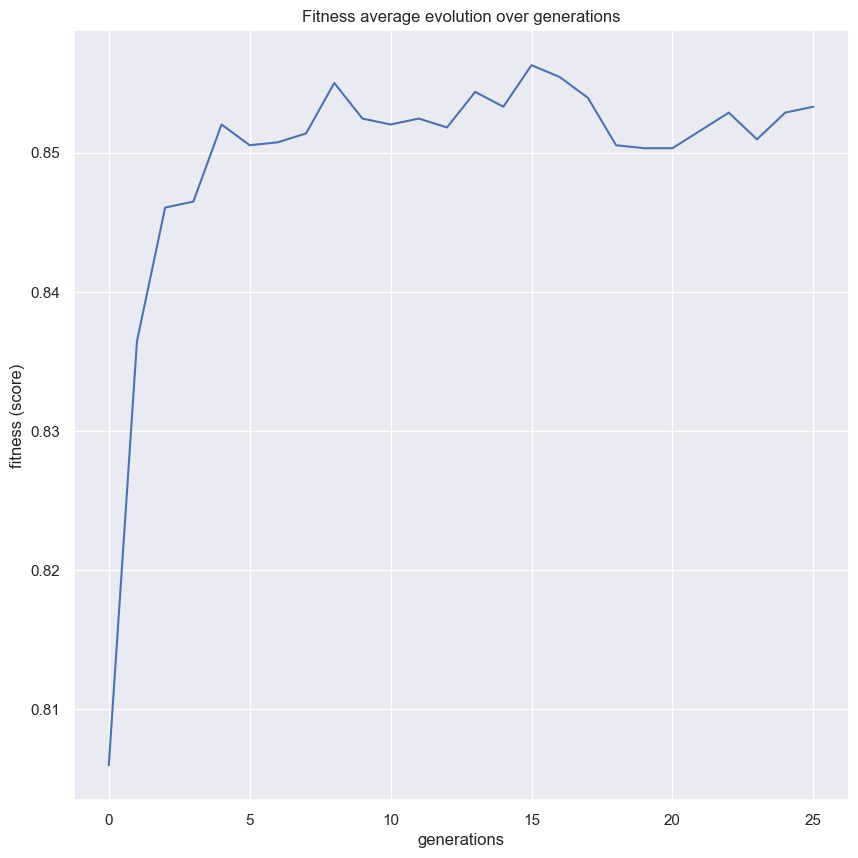

In [36]:
plot_fitness_evolution(evolved_classifier)

<Axes: title={'center': 'Fitness_std average evolution over generations'}, xlabel='generations', ylabel='fitness (score)'>

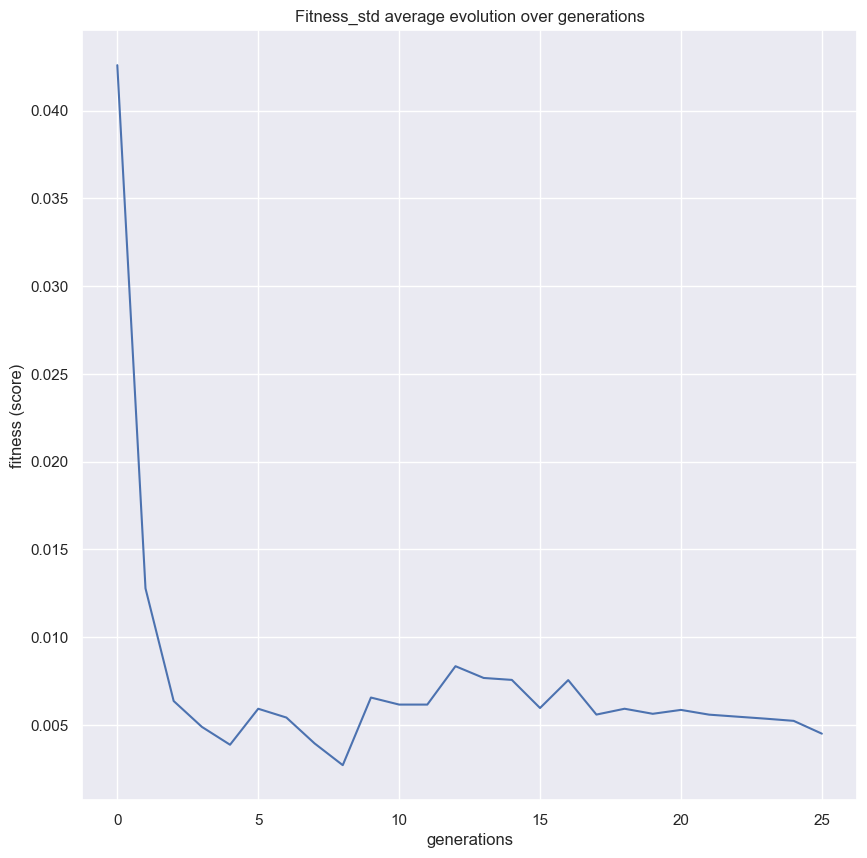

In [37]:
plot_fitness_evolution(evolved_classifier, metric='fitness_std')

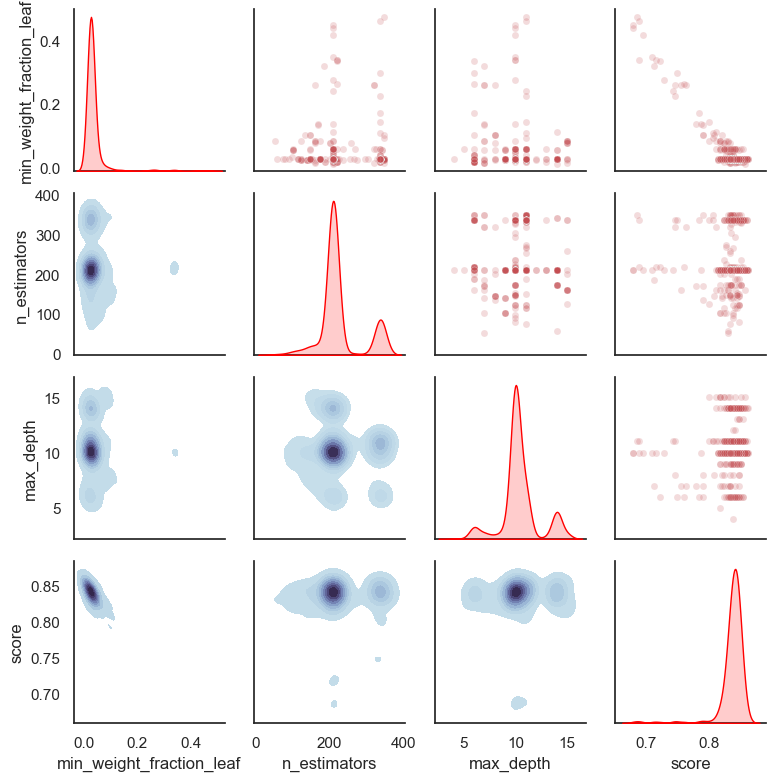

In [38]:
plot_search_space(evolved_classifier)

In [39]:
evolved_classifier.cv_results_.keys()

dict_keys(['param_min_weight_fraction_leaf', 'param_criterion', 'param_n_estimators', 'param_max_depth', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score', 'rank_train_score', 'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'params'])

### Feature Selection

In [18]:
pipe = Pipeline([("scaler", StandardScaler()), ("clf", clf)])

In [19]:
evolved_fs = GAFeatureSelectionCV(
             estimator=pipe,
             cv=3,
             scoring="accuracy",
             population_size=20,
             generations=15,
             n_jobs=-1,
             verbose=False,
             algorithm='eaMuCommaLambda')

In [20]:
mutation_adapter = ExponentialAdapter(initial_value=0.8, end_value=0.2, adaptive_rate=0.1)
crossover_adapter = ExponentialAdapter(initial_value=0.2, end_value=0.8, adaptive_rate=0.1)

cv = StratifiedKFold(n_splits=3, shuffle=True)

In [21]:
callbacks = [ThresholdStopping(threshold=0.95, metric='fitness'), 
             DeltaThreshold(threshold=0.001, metric='fitness')]

In [22]:
mlflow_config = MLflowConfig(
    tracking_uri="http://localhost:8080",
    experiment="sklearn-genetic-opt",
    run_name="FS Pipeline",
    save_models=True,
    tags={"team": "sklearn-genetic-opt", "version": "0.10.1"})

In [23]:
evolved_estimator = GAFeatureSelectionCV(estimator=pipe,
                                       cv=cv,
                                       scoring='accuracy',
                                       population_size=20,
                                       generations=10,
                                       mutation_probability=mutation_adapter,
                                       crossover_probability=crossover_adapter,
                                       log_config=mlflow_config,
                                       n_jobs=-1)

# Train and optimize the estimator
evolved_estimator.fit(X_train, y_train, callbacks=callbacks)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	20    	0.744482	0.077079   	0.853711   	0.543249   
1  	40    	0.810872	0.0362172  	0.853711   	0.692541   
2  	40    	0.797327	0.0495646  	0.838723   	0.686562   
3  	40    	0.817656	0.03047    	0.844621   	0.734422   
4  	40    	0.827174	0.0229556  	0.844809   	0.731499   
5  	40    	0.817989	0.0367228  	0.844621   	0.707502   
6  	40    	0.811174	0.0362849  	0.844621   	0.6838     
7  	40    	0.813499	0.0418824  	0.844621   	0.713374   
8  	40    	0.835048	0.0260682  	0.862693   	0.737371   
9  	40    	0.836402	0.0221235  	0.86575    	0.773059   
10 	40    	0.837174	0.025918   	0.86575    	0.764077   
INFO: DeltaThreshold callback met its criteria
INFO: Stopping the algorithm


GAFeatureSelectionCV(crossover_probability=<sklearn_genetic.schedules.schedulers.ExponentialAdapter object at 0x00000183061E4D90>,
                     cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
                     estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                               ('clf',
                                                RandomForestClassifier(max_depth=8,
                                                                       min_weight_fraction_leaf=0.01766614765267404,
                                                                       n_estimators=234,
                                                                       random_state=42))]),
                     generations=10,
                     log_config=<sklearn_genetic.mlflow_log.MLflowConfig object at 0x000001830937A150>,
                     mutation_probability=<sklearn_genetic.schedules.schedulers.ExponentialAdapter object at 0x00000183093FB810>,
                     n_jobs=-1, population_size=20, scoring='accuracy')

In [24]:
## Selected features

evolved_estimator.support_

array([ True, False, False, False,  True,  True, False,  True,  True,
        True])

In [25]:
# Convert the original input to the selected input
evolved_estimator.transform(X_test).shape

(165, 6)

In [26]:
y_predict_ga = evolved_estimator.predict(X_test)

print("test score: ", accuracy_score(y_test, y_predict_ga))


test score:  0.8


<Axes: title={'center': 'Fitness average evolution over generations'}, xlabel='generations', ylabel='fitness (score)'>

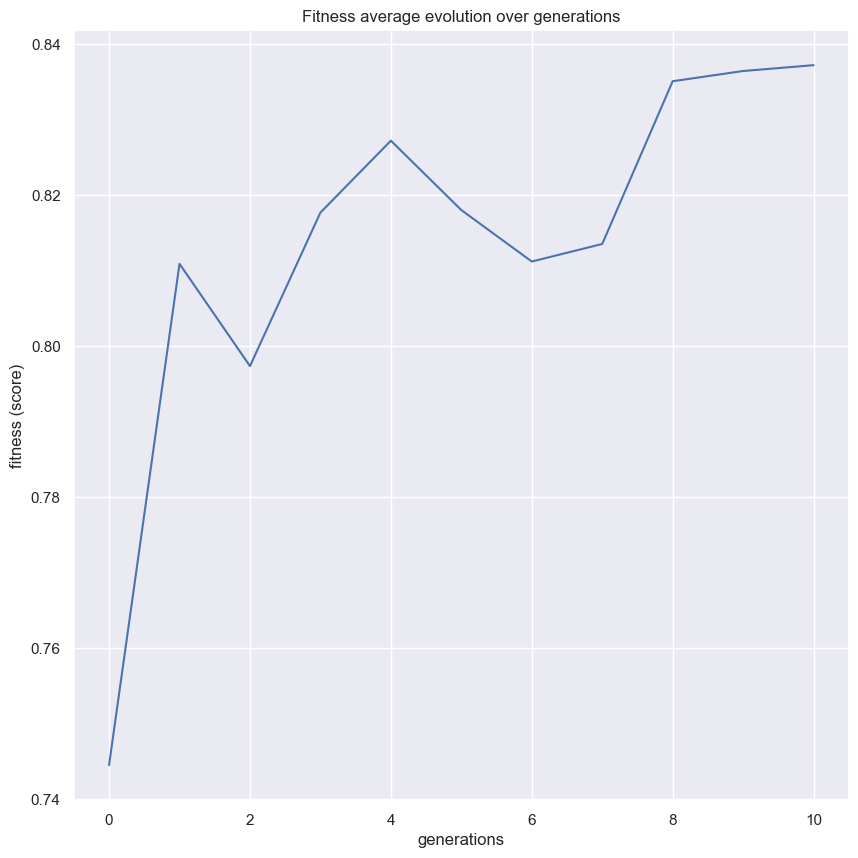

In [27]:
plot_fitness_evolution(evolved_estimator, metric="fitness")

### Other Frameworks

[scikit-optimize](https://scikit-optimize.github.io/stable/index.html)

In [42]:
skopt_search = {
    'min_weight_fraction_leaf': Real(0.01, 0.5, prior='log-uniform'),
    'max_depth': SkoptInteger(2, 15),
    'n_estimators': SkoptInteger(50, 350),
    'criterion': SkoptCategorical(['gini', 'entropy'])
}

opt = BayesSearchCV(
    clf,
    # (parameter space, # of evaluations)
    [(skopt_search, 40)],
    cv=3
)

opt.fit(X_train, y_train)

BayesSearchCV(cv=3,
              estimator=RandomForestClassifier(max_depth=10,
                                               min_weight_fraction_leaf=0.026184681884111247,
                                               n_estimators=210,
                                               random_state=42),
              search_spaces=[({'criterion': Categorical(categories=('gini', 'entropy'), prior=None),
                               'max_depth': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                               'min_weight_fraction_leaf': Real(low=0.01, high=0.5, prior='log-uniform', transform='normalize'),
                               'n_estimators': Integer(low=50, high=70, prior='uniform', transform='normalize')},
                              40)])

In [43]:
print("val. score: ", opt.best_score_)
print("test score: ", accuracy_score(y_test, opt.predict(X_test)))

print("best params: ", opt.best_params_)

val. score:  0.8328775203775205
test score:  0.806060606060606
best params:  OrderedDict([('criterion', 'gini'), ('max_depth', 7), ('min_weight_fraction_leaf', 0.01), ('n_estimators', 70)])


[FLAML](https://microsoft.github.io/FLAML/)

In [30]:
automl = AutoML()

automl_settings = {
    "time_budget": 5*60,  
    "metric": "accuracy",
    "task": "classification",
    "early_stop": True,
    "log_file_name": "aitinkers.log",
}

In [31]:
automl.fit(X_train=X_train, y_train=y_train, **automl_settings)

[flaml.automl.logger: 05-22 22:05:06] {1680} INFO - task = classification
[flaml.automl.logger: 05-22 22:05:06] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 05-22 22:05:06] {1789} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 05-22 22:05:06] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 05-22 22:05:06] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 05-22 22:05:06] {2345} INFO - Estimated sufficient time budget=1063s. Estimated necessary time budget=25s.
[flaml.automl.logger: 05-22 22:05:07] {2392} INFO -  at 0.1s,	estimator lgbm's best error=0.2358,	best estimator lgbm's best error=0.2358
[flaml.automl.logger: 05-22 22:05:07] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 05-22 22:05:07] {2392} INFO -  at 0.5s,	estimator lgbm's best error=0.2358,	best estimator lgbm's best error=0.2358
[flaml.automl.logger: 05-22 22:05:

In [32]:
automl.model.estimator

LGBMClassifier(learning_rate=0.9383215108558886, max_bin=1023,
               min_child_samples=6, n_estimators=1, n_jobs=-1, num_leaves=51,
               reg_alpha=0.006625970433730808, reg_lambda=0.8054694811834465,
               verbose=-1)

In [34]:
automl.best_config

{'n_estimators': 11,
 'num_leaves': 51,
 'min_child_samples': 6,
 'learning_rate': 0.9383215108558886,
 'log_max_bin': 10,
 'colsample_bytree': 1.0,
 'reg_alpha': 0.006625970433730808,
 'reg_lambda': 0.8054694811834465}

In [35]:
print("test score: ", accuracy_score(y_test, automl.predict(X_test)))

test score:  0.8424242424242424


[Optuna](https://optuna.org/)

In [9]:
def objective(trial):
    optuna_params = {
    'min_weight_fraction_leaf': trial.suggest_float('min_weight_fraction_leaf', 0.01, 0.5, log=True),
    'max_depth': trial.suggest_int('max_depth', 2, 15),
    'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy'])}
    
    clf = RandomForestClassifier(random_state=42, **optuna_params)
    return cross_val_score(clf, X_train, y_train, n_jobs=-1, cv=3).mean()

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-05-23 09:15:07,386] A new study created in memory with name: no-name-be7bbd32-6f69-4225-8eee-01235eda213a
[I 2024-05-23 09:15:07,570] Trial 0 finished with value: 0.8150203775203776 and parameters: {'min_weight_fraction_leaf': 0.033519370153841224, 'max_depth': 15, 'criterion': 'gini'}. Best is trial 0 with value: 0.8150203775203776.
[I 2024-05-23 09:15:07,741] Trial 1 finished with value: 0.770109395109395 and parameters: {'min_weight_fraction_leaf': 0.1495647310634648, 'max_depth': 14, 'criterion': 'gini'}. Best is trial 0 with value: 0.8150203775203776.
[I 2024-05-23 09:15:07,924] Trial 2 finished with value: 0.8209995709995711 and parameters: {'min_weight_fraction_leaf': 0.02219336574635508, 'max_depth': 15, 'criterion': 'entropy'}. Best is trial 2 with value: 0.8209995709995711.
[I 2024-05-23 09:15:08,065] Trial 3 finished with value: 0.7642106392106393 and parameters: {'min_weight_fraction_leaf': 0.08236647608110764, 'max_depth': 2, 'criterion': 'gini'}. Best is trial 2 w

In [11]:
optuna_clf = RandomForestClassifier(random_state=42, **study.best_params)
optuna_clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10,
                       min_weight_fraction_leaf=0.0246477245232361,
                       random_state=42)

In [12]:
print("val. score: ", study.best_value)
print("best params: ", study.best_params)
print("test score: ", accuracy_score(y_test, optuna_clf.predict(X_test)))

val. score:  0.824002574002574
best params:  {'min_weight_fraction_leaf': 0.0246477245232361, 'max_depth': 10, 'criterion': 'entropy'}
test score:  0.793939393939394
